### Imports, Load data, define utils ... 

In [1]:
#!pip install datasets
from datasets import load_dataset

#import warnings
#warnings.filterwarnings("ignore")

import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")
from sklearn.metrics import auc, roc_curve, precision_score, recall_score, precision_recall_curve

import optuna
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from xgboost import XGBClassifier


import numpy as np

/Users/mounir/Desktop/PROJETS/Statapp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup Complete


In [2]:
ds = load_dataset("criteo/FairJob")
df = ds['train'].to_pandas()

In [3]:
from sklearn.metrics import log_loss

def print_results(X_test, y_test, model):
    # Calcul des probabilités des prédictions
    y_scores = model.predict_proba(X_test)[:, 1]  # Probabilité d'être classe 1

    # Calcul des courbes précision-rappel
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

    # Calcul du F1-score pour chaque seuil
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)  # Évite division par zéro

    # Trouver l'index du meilleur F1-score
    best_threshold_index = np.argmax(f1_scores)

    # Le tableau "thresholds" est plus court d'un élément → il faut ajuster l'indexation
    if best_threshold_index == 0:  # Si le max est au début, on prend le premier seuil
        best_threshold = thresholds[0]
    else:
        best_threshold = thresholds[best_threshold_index - 1]

    # Précision et rappel au meilleur seuil
    precision_optimal = precisions[best_threshold_index]
    recall_optimal = recalls[best_threshold_index]
    f1_score_optimal = f1_scores[best_threshold_index]

    # Calcul du log loss
    log_loss_value = log_loss(y_test, y_scores)

    print(f'Best Threshold: {best_threshold}')
    print(f'\nPrecision at Best Threshold: {precision_optimal}')
    print(f'Recall at Best Threshold: {recall_optimal}')
    print(f'F1 Score at Best Threshold: {f1_score_optimal}')
    print(f'Log Loss: {log_loss_value}')

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions[1:], label='Précision', color='blue')
    plt.plot(thresholds, recalls[1:], label='Recall', color='red')
    plt.axvline(x=best_threshold, color='green', linestyle='--', label="Seuil Optimal")
    plt.xlabel("Seuil de classification")
    plt.ylabel("Score")
    plt.title("Courbe Précision-Recall en fonction du seuil")
    plt.legend()
    plt.grid()
    plt.show()


In [4]:
from sklearn.metrics import log_loss
import numpy as np

def evaluate_log_loss_by_class(y_true, y_proba):
    """
    Calcule la log loss globale, la log loss par classe, et la confiance moyenne sur les vrais positifs.
    
    Parameters
    ----------
    y_true : array-like
        Vecteur des vraies étiquettes (0 ou 1)
    y_proba : array-like, shape (n_samples, 2)
        Probabilités prédites (sorties de predict_proba)

    Returns
    -------
    dict with:
        - 'log_loss_global'
        - 'log_loss_y0'
        - 'log_loss_y1'
        - 'mean_proba_y1' (moyenne des p(y=1) quand y=1)
    """
    y_true = np.array(y_true)
    y_proba = np.array(y_proba)

    return {
        "log_loss_global": round(log_loss(y_true, y_proba), 5),
        "log_loss_y0": round(log_loss(y_true[y_true == 0], y_proba[y_true == 0], labels=[0, 1]), 5),
        "log_loss_y1": round(log_loss(y_true[y_true == 1], y_proba[y_true == 1], labels=[0, 1]), 5),
        "mean_proba_y1": round(float(y_proba[y_true == 1, 1].mean()), 5)
        }



In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['click','user_id','impression_id','product_id'])
y = df['click']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Baseline

In [13]:
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from xgboost import XGBClassifier


xgb_tree_method = "hist"

cat_cols_bin = list(X_train.columns[0:3])
rank_col = ['rank']
cat_cols = list(X_train.columns[4:17])

data_preproc = ColumnTransformer([('multicat_encoding', TargetEncoder(target_type='binary'), cat_cols)], 
                              remainder='passthrough', force_int_remainder_cols=False)

xgb_pipe = Pipeline([('preprocessing', data_preproc),
                     ('xgb',XGBClassifier())])

xgb_base_params = {
    'xgb__max_depth': 10,
    'xgb__learning_rate': 0.001,
    'xgb__scale_pos_weight': 1,
    'xgb__random_state' : 42,
    'xgb__eval_metric' : 'logloss'
}
    
xgb_pipe.set_params(**xgb_base_params)
xgb_pipe.fit(X_train, y_train)

print("\nEntrainement terminé")

baseline_results = evaluate_log_loss_by_class(y_test, xgb_pipe.predict_proba(X_test))


Entrainement terminé


### Tuning parameters

In [15]:
# XGB with tuning and scale log loss

import optuna
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss

cat_cols_bin = list(X_train.columns[0:3])
rank_col = ['rank']
cat_cols = list(X_train.columns[4:17])

data_preproc = ColumnTransformer([('multicat_encoding', TargetEncoder(target_type='binary'), cat_cols)], 
                              remainder='passthrough', force_int_remainder_cols=False)

xgb_pipe = Pipeline([('preprocessing', data_preproc),
                     ('xgb',XGBClassifier())])

def objective(trial):
    X_train_train, X_val, y_train_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train
    )

    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_child_weight = trial.suggest_float("min_child_weight", 0.0001, 100, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1, log=True)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)
    reg_lambda = trial.suggest_float("reg_lambda", 0.1, 10, log=True)
    gamma = trial.suggest_float("gamma", 0.001, 100, log=True)
    base_score = trial.suggest_float("base_score", 1e-4, 1 - 1e-4)
    
    
    # scale_pos_weight = (
    #     (np.sum(y_train_train < 1) / np.sum(y_train_train > 0))
    # )
    scale_pos_weight = 1
    
    xgb_params = {
        'xgb__max_depth': max_depth,
        'xgb__min_child_weight': min_child_weight,
        'xgb__subsample': subsample,
        'xgb__learning_rate': learning_rate,
        'xgb__colsample_bytree': colsample_bytree,
        'xgb__reg_lambda': reg_lambda,
        'xgb__gamma': gamma,
        'xgb__base_score': base_score,
        'xgb__scale_pos_weight': scale_pos_weight,
    }
    
    xgb_pipe.set_params(**xgb_params)
    xgb_pipe.fit(X_train_train, y_train_train)

    prob_val = xgb_pipe.predict_proba(X_val)
    ## Give more weight to label 1 in the hyper-tuning utility
    scale_pos_weight_val_loss = (
        (np.sum(y_train_train < 1) / np.sum(y_train_train > 0))
    ) # Try to play with this value to focus more on positive labels
    sample_weight = np.ones_like(y_val)
    sample_weight[y_val==1] = scale_pos_weight_val_loss
    
    return log_loss(y_val, prob_val, sample_weight=sample_weight)

n_trials = 100 # Increase to ~100

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=n_trials)
optimal_no_scale = study.best_trial

print("\nOptimization done")

scale_pos_weight = 1

xgb_tuned_params = {
    'xgb__max_depth': optimal_no_scale.params["max_depth"],
    'xgb__min_child_weight': optimal_no_scale.params["min_child_weight"],
    'xgb__gamma': optimal_no_scale.params["gamma"],
    'xgb__subsample': optimal_no_scale.params["subsample"],
    'xgb__learning_rate': optimal_no_scale.params["learning_rate"],
    'xgb__colsample_bytree': optimal_no_scale.params["colsample_bytree"],
    'xgb__reg_lambda': optimal_no_scale.params["reg_lambda"],
    'xgb__base_score': optimal_no_scale.params["base_score"],
    'xgb__scale_pos_weight': scale_pos_weight,
}
    
xgb_pipe.set_params(**xgb_tuned_params)
xgb_pipe.fit(X_train, y_train)

print("\nEntrainement terminé")

xgb_fixed_scale_tuned = evaluate_log_loss_by_class(y_test, xgb_pipe.predict_proba(X_test))

[I 2025-04-09 17:10:51,705] A new study created in memory with name: no-name-60fbd27b-ff4a-4923-8a32-43070def6006
[I 2025-04-09 17:10:57,782] Trial 0 finished with value: 2.013848324772044 and parameters: {'max_depth': 3, 'min_child_weight': 6.532715392627165, 'subsample': 0.8865719596231797, 'learning_rate': 0.30554684299580037, 'colsample_bytree': 0.9691198297715417, 'reg_lambda': 0.2135175947230919, 'gamma': 0.03138106367037423, 'base_score': 0.5720431009092377}. Best is trial 0 with value: 2.013848324772044.
[I 2025-04-09 17:11:03,010] Trial 1 finished with value: 2.0178805127798953 and parameters: {'max_depth': 4, 'min_child_weight': 0.10356367211280361, 'subsample': 0.5933042087896842, 'learning_rate': 0.42871742294666004, 'colsample_bytree': 0.5743977053960443, 'reg_lambda': 0.3032842119534899, 'gamma': 16.557756706593125, 'base_score': 0.9183971126717149}. Best is trial 0 with value: 2.013848324772044.
[I 2025-04-09 17:11:08,382] Trial 2 finished with value: 2.0428582716747856 


Optimization done

Entrainement terminé


In [12]:
evaluate_log_loss_by_class(y_test, xgb_pipe.predict_proba(X_test))

{'log_loss_global': 0.05496,
 'log_loss_y0': 0.03267,
 'log_loss_y1': 3.22365,
 'mean_proba_y1': 0.04148}

In [16]:
scale_pos_weight = (
        (np.sum(y_train < 1) / np.sum(y_train > 0))
    )

def objective_scale(trial):
    X_train_train, X_val, y_train_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train
    )

    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_child_weight = trial.suggest_float("min_child_weight", 0.0001, 100, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1, log=True)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)
    reg_lambda = trial.suggest_float("reg_lambda", 0.1, 10, log=True)
    gamma = trial.suggest_float("gamma", 0.001, 100, log=True)
    base_score = trial.suggest_float("base_score", 1e-4, 1 - 1e-4)

    
    xgb_params = {
        'xgb__max_depth': max_depth,
        'xgb__min_child_weight': min_child_weight,
        'xgb__subsample': subsample,
        'xgb__learning_rate': learning_rate,
        'xgb__colsample_bytree': colsample_bytree,
        'xgb__reg_lambda': reg_lambda,
        'xgb__gamma': gamma,
        'xgb__base_score': base_score,
        'xgb__scale_pos_weight': scale_pos_weight,
    }
    
    xgb_pipe.set_params(**xgb_params)
    xgb_pipe.fit(X_train_train, y_train_train)

    prob_val = xgb_pipe.predict_proba(X_val)
    
    return log_loss(y_val, prob_val)

n_trials = 100 # Increase to ~100

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=n_trials)
optimal_no_scale = study.best_trial

print("\nOptimization done")

xgb_tuned_params = {
    'xgb__max_depth': optimal_no_scale.params["max_depth"],
    'xgb__min_child_weight': optimal_no_scale.params["min_child_weight"],
    'xgb__gamma': optimal_no_scale.params["gamma"],
    'xgb__subsample': optimal_no_scale.params["subsample"],
    'xgb__learning_rate': optimal_no_scale.params["learning_rate"],
    'xgb__colsample_bytree': optimal_no_scale.params["colsample_bytree"],
    'xgb__reg_lambda': optimal_no_scale.params["reg_lambda"],
    'xgb__base_score': optimal_no_scale.params["base_score"],
    'xgb__scale_pos_weight': scale_pos_weight,
}
    
xgb_pipe.set_params(**xgb_tuned_params)
xgb_pipe.fit(X_train, y_train)

print("\nEntrainement terminé")

xgb_adapted_scale_tuned = evaluate_log_loss_by_class(y_test, xgb_pipe.predict_proba(X_test))

[I 2025-04-09 19:33:33,220] A new study created in memory with name: no-name-4d7bac7f-f1b4-497f-b161-306523ac653a
[I 2025-04-09 19:33:41,724] Trial 0 finished with value: 2.1015464790596434 and parameters: {'max_depth': 5, 'min_child_weight': 1.4525531449332056, 'subsample': 0.8548490856833143, 'learning_rate': 0.5912387394208408, 'colsample_bytree': 0.7126563226325044, 'reg_lambda': 7.489020660514272, 'gamma': 0.7348063957773815, 'base_score': 0.11812689305249797}. Best is trial 0 with value: 2.1015464790596434.
[I 2025-04-09 19:33:51,552] Trial 1 finished with value: 1.1010913790285757 and parameters: {'max_depth': 9, 'min_child_weight': 0.11402955229561719, 'subsample': 0.5484440243749034, 'learning_rate': 0.005949733065882082, 'colsample_bytree': 0.9578084726726601, 'reg_lambda': 1.275269516201956, 'gamma': 0.001645416124313216, 'base_score': 0.2029524464964687}. Best is trial 1 with value: 1.1010913790285757.
[I 2025-04-09 19:33:57,228] Trial 2 finished with value: 0.9117565499145


Optimization done

Entrainement terminé


In [17]:
# Finetuning scale_pos_weight xgb parameter

xgb_pipe = Pipeline([('preprocessing', data_preproc),
                     ('xgb',XGBClassifier())])

def objective(trial):
    X_train_train, X_val, y_train_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train
    )

    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_child_weight = trial.suggest_float("min_child_weight", 0.0001, 100, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1, log=True)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)
    reg_lambda = trial.suggest_float("reg_lambda", 0.1, 10, log=True)
    gamma = trial.suggest_float("gamma", 0.001, 100, log=True)
    base_score = trial.suggest_float("base_score", 1e-4, 1 - 1e-4)
    scale_pos_weight = trial.suggest_float("scale_pos_weight", 1, 100, log=True)
    
    xgb_params = {
        'xgb__max_depth': max_depth,
        'xgb__min_child_weight': min_child_weight,
        'xgb__subsample': subsample,
        'xgb__learning_rate': learning_rate,
        'xgb__colsample_bytree': colsample_bytree,
        'xgb__reg_lambda': reg_lambda,
        'xgb__gamma': gamma,
        'xgb__base_score': base_score,
        'xgb__scale_pos_weight': scale_pos_weight,
    }
    
    xgb_pipe.set_params(**xgb_params)
    xgb_pipe.fit(X_train_train, y_train_train)

    prob_val = xgb_pipe.predict_proba(X_val)
    
    return log_loss(y_val, prob_val)

n_trials = 100 # Increase to ~100

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=n_trials)
optimal_no_scale = study.best_trial

print("\nOptimization done")

xgb_tuned_params_including_scale = {
    'xgb__max_depth': optimal_no_scale.params["max_depth"],
    'xgb__min_child_weight': optimal_no_scale.params["min_child_weight"],
    'xgb__gamma': optimal_no_scale.params["gamma"],
    'xgb__subsample': optimal_no_scale.params["subsample"],
    'xgb__learning_rate': optimal_no_scale.params["learning_rate"],
    'xgb__colsample_bytree': optimal_no_scale.params["colsample_bytree"],
    'xgb__reg_lambda': optimal_no_scale.params["reg_lambda"],
    'xgb__base_score': optimal_no_scale.params["base_score"],
    'xgb__scale_pos_weight': optimal_no_scale.params["scale_pos_weight"],
}
    
xgb_pipe.set_params(**xgb_tuned_params_including_scale)
xgb_pipe.fit(X_train, y_train)

print("\nEntrainement terminé")

xgb_scale_parameter_tuned = evaluate_log_loss_by_class(y_test, xgb_pipe.predict_proba(X_test))

[I 2025-04-09 20:19:52,907] A new study created in memory with name: no-name-c9203ebb-92fb-44f7-9bb4-feb58aa81170
[I 2025-04-09 20:20:01,554] Trial 0 finished with value: 0.07398531222533879 and parameters: {'max_depth': 5, 'min_child_weight': 13.242858900159776, 'subsample': 0.7588813034160147, 'learning_rate': 0.9914842092099881, 'colsample_bytree': 0.7787173512588876, 'reg_lambda': 0.22181809875867284, 'gamma': 55.94503347975341, 'base_score': 0.12694240690782976, 'scale_pos_weight': 9.261034316468324}. Best is trial 0 with value: 0.07398531222533879.
[I 2025-04-09 20:20:08,836] Trial 1 finished with value: 1.596513369005752 and parameters: {'max_depth': 9, 'min_child_weight': 6.654434283777537, 'subsample': 0.9263995093346877, 'learning_rate': 0.001016803961082028, 'colsample_bytree': 0.9116061810953904, 'reg_lambda': 0.21675407119012668, 'gamma': 0.008308545054225788, 'base_score': 0.8840279253274114, 'scale_pos_weight': 1.5481219363972427}. Best is trial 0 with value: 0.073985312


Optimization done

Entrainement terminé


### Benchmark

In [19]:
results = {
    'baseline' : baseline_results,
    'xgb scale_pos_weight = 1 and weight loss' : xgb_fixed_scale_tuned,
    'xgb scale_pos_weight = ratio 0:1' : xgb_adapted_scale_tuned,
    'xgb scale_pos_weight parameter tuned' : xgb_scale_parameter_tuned,   
}

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results

,log_loss_global,log_loss_y0,log_loss_y1,mean_proba_y1
baseline,0.13223,0.11786,2.17462,0.11379
xgb scale_pos_weight = 1 and weight loss,0.73561,0.73627,0.64088,0.52689
xgb scale_pos_weight = ratio 0:1,0.88690,0.89063,0.35564,0.70707
xgb scale_pos_weight parameter tuned,0.03496,0.00760,3.92472,0.04359


### Results for best params (with protected_attribute)

In [11]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # pour remonter d'un dossier

from functions import report_results


In [12]:
# Define preprocess + pipeline

cat_cols_bin = list(X_train.columns[0:3])
rank_col = ['rank']
cat_cols = list(X_train.columns[4:17])

data_preproc = ColumnTransformer([('multicat_encoding', TargetEncoder(target_type='binary'), cat_cols)], 
                              remainder='passthrough', force_int_remainder_cols=False)

xgb_pipe = Pipeline([('preprocessing', data_preproc),
                     ('xgb',XGBClassifier())])

# Set params

scale_pos_weight = (
        (np.sum(y_train < 1) / np.sum(y_train > 0))
    )

params = {
    'xgb__max_depth': 9, 
    'xgb__min_child_weight': 0.0001571124384178228, 
    'xgb__subsample': 0.7648038086116782, 
    'xgb__learning_rate': 0.00497357053166194, 
    'xgb__colsample_bytree': 0.7245817577957009, 
    'xgb__reg_lambda': 0.4999935268511382, 
    'xgb__gamma': 2.0806419432420054, 
    'xgb__base_score': 0.7790489714094901,
    'xgb__scale_pos_weight' : scale_pos_weight
    }

xgb_pipe.set_params(**params)
xgb_pipe.fit(X_train, y_train)
prob = xgb_pipe.predict_proba(X_test)

Best Threshold: 0.8072464466094971

Precision at Best Threshold: 0.11241970021413276
Recall at Best Threshold: 0.14018691588785046
F1 Score at Best Threshold: 0.12477718310675451
Log Loss: 0.8873247216931864


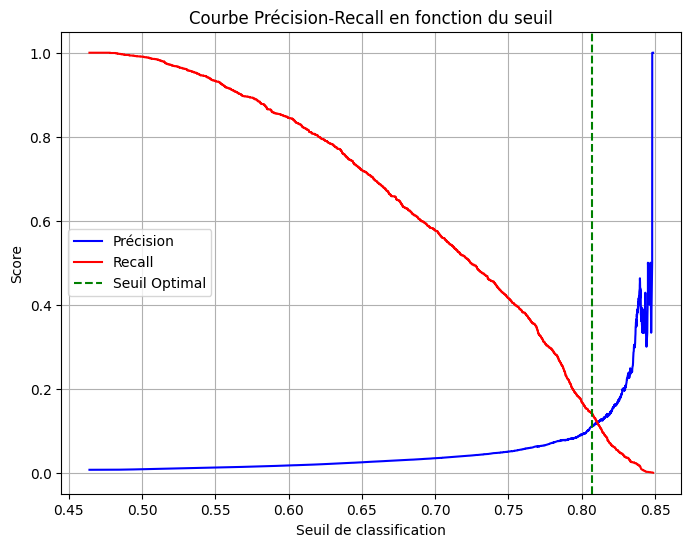

In [13]:
model = xgb_pipe.named_steps['xgb']
print_results(X_test, y_test, xgb_pipe)

In [17]:
best_threshold = 0.8059098720550537

y_pred_proba = pd.Series(prob[:, 1], index=X_test.index)
y_pred = (y_pred_proba > best_threshold).astype(int)
report_results(df, y_pred_proba, y_pred)

{'Click Rank Utility': np.float64(0.00924),
 'Negative Log-Likelihood': np.float64(0.88732),
 'AUC': np.float64(0.84061),
 'Demographic Parity': np.float64(-0.00385)}

### Results for best params (without protected_attribute)

In [5]:
xgb_tree_method = "hist"

cat_cols_bin = list(X_train.columns[0:3])
rank_col = ['rank']
cat_cols = list(X_train.columns[4:17])

data_preproc = ColumnTransformer([('multicat_encoding', TargetEncoder(target_type='binary'), cat_cols)], 
                              remainder='passthrough', force_int_remainder_cols=False)

NameError: name 'X_train' is not defined

In [ ]:
scale_pos_weight = (
        (np.sum(y_train < 1) / np.sum(y_train > 0))
    )

def objective_scale(trial):
    X_train_train, X_val, y_train_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train
    )

    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_child_weight = trial.suggest_float("min_child_weight", 0.0001, 100, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1, log=True)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)
    reg_lambda = trial.suggest_float("reg_lambda", 0.1, 10, log=True)
    gamma = trial.suggest_float("gamma", 0.001, 100, log=True)
    base_score = trial.suggest_float("base_score", 1e-4, 1 - 1e-4)

    
    xgb_params = {
        'xgb__max_depth': max_depth,
        'xgb__min_child_weight': min_child_weight,
        'xgb__subsample': subsample,
        'xgb__learning_rate': learning_rate,
        'xgb__colsample_bytree': colsample_bytree,
        'xgb__reg_lambda': reg_lambda,
        'xgb__gamma': gamma,
        'xgb__base_score': base_score,
        'xgb__scale_pos_weight': scale_pos_weight,
    }
    
    xgb_pipe.set_params(**xgb_params)
    xgb_pipe.fit(X_train_train, y_train_train)

    prob_val = xgb_pipe.predict_proba(X_val)
    
    return log_loss(y_val, prob_val)

n_trials = 100 # Increase to ~100

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=n_trials)
optimal_no_scale = study.best_trial

print("\nOptimization done")

xgb_tuned_params = {
    'xgb__max_depth': optimal_no_scale.params["max_depth"],
    'xgb__min_child_weight': optimal_no_scale.params["min_child_weight"],
    'xgb__gamma': optimal_no_scale.params["gamma"],
    'xgb__subsample': optimal_no_scale.params["subsample"],
    'xgb__learning_rate': optimal_no_scale.params["learning_rate"],
    'xgb__colsample_bytree': optimal_no_scale.params["colsample_bytree"],
    'xgb__reg_lambda': optimal_no_scale.params["reg_lambda"],
    'xgb__base_score': optimal_no_scale.params["base_score"],
    'xgb__scale_pos_weight': scale_pos_weight,
}
    
xgb_pipe.set_params(**xgb_tuned_params)
xgb_pipe.fit(X_train, y_train)

print("\nEntrainement terminé")

xgb_adapted_scale_tuned = evaluate_log_loss_by_class(y_test, xgb_pipe.predict_proba(X_test))